# Likelihood functions in HSSM explained

One of the design goals of HSSM is its flexibility. It is built from ground up to support many types of likelihood functions out-of-the-box. For more tailored applications, HSSM provides a convenient toolbox. This allows users to create their own likelihood functions, which can seamlessly integrate with the HSSM class, facilitating a highly customizable analysis environment. This notebook focuses on explaining how to use different types of likelihoods with HSSM.

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://github.com/lnccbrown/HSSM/blob/main/docs/tutorials/likelihoods.ipynb). 

Once you are *in the colab*, follow the *installation instructions below* and then **restart your runtime**. 

Just **uncomment the code in the next code cell** and run it!

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.

Note that if you switch your runtime you have to follow the installation instructions again.

In [1]:
# If running this on Colab, please uncomment the next line
# !pip install hssm

## Load Modules

In [2]:
import numpy as np
import pytensor
import hssm

In [3]:
help(hssm.simulate_data)

Help on function simulate_data in module hssm.simulator:

simulate_data(model: str, theta: Union[dict[str, Union[numpy._typing._array_like._Buffer, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], complex, bytes, str, numpy._typing._nested_sequence._NestedSequence[complex | bytes | str]]], list[float], numpy._typing._array_like._Buffer, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], complex, bytes, str, numpy._typing._nested_sequence._NestedSequence[complex | bytes | str]], size: int, random_state: int | None = None, output_df: bool = True, **kwargs) -> numpy.ndarray | pandas.core.frame.DataFrame
    Sample simulated data from specified distributions.
    
    Parameters
    ----------
    model
        A model name that must be supported in `ssm_sim

## Pre-simulate some data

In [4]:
# Simulate some data
data = hssm.simulate_data(
    model="ddm", theta=dict(v=0.5, a=1.5, z=0.5, t=0.3), size=1000
)
data

,rt,response
0,1.045665,1.0
1,2.170658,1.0
2,1.184247,1.0
3,4.467735,1.0
4,1.289009,1.0
...,...,...
995,1.803433,1.0
996,2.017609,1.0
997,3.286063,1.0
998,1.840125,1.0


## Three Kinds of Likelihoods

HSSM supports 3 kinds of likelihood functions supported via the `loglik_kind` parameter to the `HSSM` class:

- `"analytical"`: These likelihoods are usually closed-form solutions to the actual likelihoods. For example, For `ddm` models, HSSM provides the analytical likelihoods in [Navarro & Fuss (2009)](https://psycnet.apa.org/record/2009-11068-003). HSSM expects these functions to be written with `pytensor`, which can be compiled by `pytensor` as part of a computational graph. As such, they are differentiable as well.
- `"approx_differentiable"`: These likelihoods are usually approximations of the actual likelihood functions with neural networks. These networks can be trained with any popular deep learning framework such as `PyTorch` and `TensorFlow` and saved as `onnx` files. HSSM can load the `onnx` files and translate the information of the neural network with either the `jax` or the `pytensor` backends. Please see below for detailed explanations for these backends. The `backend` option can be supplied via the `"backend"` field in `model_config`. This field of `model_config` is not applicable to other kinds of likelihoods.

  - the `jax` backend: The basic computations in the likelihood are jax operations (valid `JAX` functions), which are wrapped in a `pytensor` `Op`. When sampling using the default NUTS sampler in `PyMC`, this option might be slightly faster but more prone to compatibility issues especially during parallel sampling due how `JAX` handles paralellism.The preferred usage of this backend is together with the `numpyro` and `blackjax` samplers. Here JAX support is native and performance is optimized.
  - the `pytensor` backend: The basic computations in the likelihood are pytensor operations (valid `pytensor` functions). When sampling using the default NUTS sampler in `PyMC`, this option allows for maximum compatibility. Not recommended when using `JAX`-based samplers.

- `"blackbox"`: Use this option for "black box" likelihoods that are not differentiable. These likelihoods are typically `Callable`s in Python that cannot be directly integrated to a `pytensor` computational graph. `hssm` will wrap these `Callable`s in a `pytensor` `Op` so it can be part of the graph.

## Default vs. Custom Likelihoods

HSSM provides many default likelihood functions out-of-the-box. The supported likelihoods are:

- For `analytical` kind: `ddm` and `ddm_sdv` models.
- For `approx_differentiable` kind: `ddm`, `ddm_sdv`, `angle`, `levy`, `ornstein`, `weibull`, `race_no_bias_angle_4` and `ddm_seq2_no_bias`.
- For `blackbox` kind: `ddm`, `ddm_sdv` and `full_ddm` models.

For a model that has default likelihood functions, only the `model` argument needs to be specified.

In [5]:
ddm_model_analytical = hssm.HSSM(data, model="ddm")

Model initialized successfully.


In [6]:
ddm_model_analytical

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

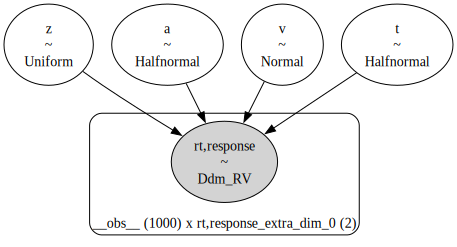

In [7]:
ddm_model_analytical.graph()

The `ddm` and `ddm_sdv` models have `analytical` and `approx_differentiable` likelihoods. If `loglik_kind` is not specified, the `analytical` likelihood will be used. We can however directly specify the `loglik_kind` argument for a given model, and if available, the likelihood backend will be switched automatically. 

In [8]:
ddm_model_approx_diff = hssm.HSSM(
    data, model="ddm", loglik_kind="approx_differentiable"
)

Model initialized successfully.


While the model graph looks the same:

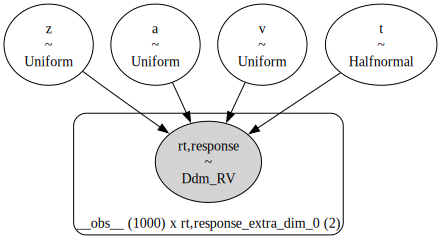

In [9]:
ddm_model_approx_diff.graph()

We can check that the likelihood is now coming from a different backend by printing the model string:

In [10]:
ddm_model_approx_diff

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -3.0, upper: 3.0)
    Explicit bounds: (-3.0, 3.0)

a:
    Prior: Uniform(lower: 0.3, upper: 2.5)
    Explicit bounds: (0.3, 2.5)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, 2.0)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

Note how under the *Likelihood* rubric, it now says "approx_differentiable". Another simple way to check this is to access the `loglik_kind` attribute of our HSSM model.

In [11]:
ddm_model_approx_diff.loglik_kind

'approx_differentiable'

### Overriding default likelihoods

Sometimes a likelihood other than the default version is preferred. In that case, you can supply a likelihood function directly to the `loglik` parameter. We will discuss acceptable likelihood function types in a moment. 

For illustration we load the basic analytical DDM likelihood, which is shipped with HSSM and supply it manually our HSSM model class.

In [12]:
from hssm.likelihoods.analytical import logp_ddm

In [13]:
ddm_model_analytical_override = hssm.HSSM(
    data, model="ddm", loglik_kind="analytical", loglik=logp_ddm
)

Model initialized successfully.


HSSM automatically constructed our model with the likelihood function we provided. We can now take posterior samples as usual.

In [14]:
idata = ddm_model_analytical_override.sample(draws=500, tune=500, chains=2)

Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, a, t, v]
/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
100%|██████████| 1000/1000 [00:00<00:00, 2803.20it/s]


In [15]:
ddm_model_analytical_override._inference_obj

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Using Custom Likelihoods

If you are specifying a model with a kind of likelihood that's not included in the list above, then HSSM considers that you are using a custom model with custom likelihoods. In this case, you will need to specify your entire model. Below is the procedure to specify a custom model:

1. Specify a `model` string. It can be any string that helps identify the model, but if it is not one of the model strings supported in the `ssm_simulators` package [see full list here](https://github.com/AlexanderFengler/ssm-simulators/blob/main/ssms/config/config.py), you will need to supply a `RandomVariable` class to `model_config` detailed below. Otherwise, you can still perform MCMC sampling, but sampling from the posterior predictive distribution will raise a ValueError.

2. Specify a `model_config`. It typically contains the following fields:

   - `"list_params"`: Required if your `model` string is not one of `ddm`, `ddm_sdv`, `full_ddm`, `angle`, `levy`, `ornstein`, `weibull`, `race_no_bias_angle_4` and `ddm_seq2_no_bias`. A list of `str` indicating the parameters of the model.
     The order in which the parameters are specified in this list is important.
     Values for each parameter will be passed to the likelihood function in this
     order.
   - `"backend"`: Optional. Only used when `loglik_kind` is `approx_differentiable` and
     an onnx file is supplied for the likelihood approximation network (LAN).
     Valid values are `"jax"` or `"pytensor"`. It determines whether the LAN in
     ONNX should be converted to `"jax"` or `"pytensor"`. If not provided,
     `jax` will be used for maximum performance.
   - `"default_priors"`: Optional. A `dict` indicating the default priors for each parameter.
   - `"bounds"`: Optional. A `dict` of `(lower, upper)` tuples indicating the acceptable boundaries for each parameter. In the case
     of LAN, these bounds are training boundaries.
   - `"rv"`: Optional. Can be a `RandomVariable` class containing the user's own
     `rng_fn` function for sampling from the distribution that the user is
     supplying. If not supplied, HSSM will automatically generate a
     `RandomVariable` using the simulator identified by `model` from the
     `ssm_simulators` package. If `model` is not supported in `ssm_simulators`,
     a warning will be raised letting the user know that sampling from the
     `RandomVariable` will result in errors.
<br> </br>     

3. Specify `loglik` and `loglik_kind`.

4. Specify parameter priors in `include`.

**NOTE**:

 `default_priors` and `bounds` in `model_config` specifies  **default** priors and bounds for the model. Actual priors and defaults should be provided via the `include` list and will override these defaults.

Below are a few examples:

```python
# An angle model with an analytical likelihood function.
# Because `model` is known, no `list_params` needs to be provided.

custom_angle_model = hssm.HSSM(
    data,
    model="angle",
    model_config={
        "bounds": {
            "v": (-3.0, 3.0),
            "a": (0.3, 3.0),
            "z": (0.1, 0.9),
            "t": (0.001, 2.0),
            "theta": (-0.1, 1.3),
        }  # bounds will be used to create Uniform (uninformative) priors by default
        # if priors are not supplied in `include`.
    },
    loglik=custom_angle_logp,
    loglik_kind="analytical",
)

# A fully customized model with a custom likelihood function.
# Because `model` is not known, a `list_params` needs to be provided.

my_custom_model = hssm.HSSM(
    data,
    model="my_model",
    model_config={
        "list_params": ["v", "a", "z", "t", "theta"],
        "bounds": {
            "v": (-3.0, 3.0),
            "a": (0.3, 3.0),
            "z": (0.1, 0.9),
            "t": (0.001, 2.0),
            "theta": (-0.1, 1.3),
        } # bounds will be used to create Uniform (uninformative) priors by default
          # if priors are not supplied in `include`.
        "default_priors": ... # usually no need to supply this.
        "rv": MyRV # provide a RandomVariable class if pps is needed.
    },
    loglik="my_model.onnx", # Can be a path to an onnx model.
    loglik_kind="approx_differentiable",
    include=[...]
)
```

## Supported types of likelihoods

When default likelihoods are not used, custom likelihoods are supplied via `loglik` argument to `HSSM`. Depending on what `loglik_kind` is used, `loglik` supports different types of Python objects:

- `Type[pm.Distribution]`: Supports all `loglik_kind`s.

  You can pass any **subclass** of `pm.Distribution` to `loglik` representing the underlying top-level distribution of the model. It has to be a class instead of an instance of the class.

- `Op`: Supports all `loglik_kind` kinds.

  You can pass a `pytensor` `Op` (an instance instead of the class itself), in which case HSSM will create a top-level `pm.Distribution`, which calls this `Op` in its `logp` function to compute the log-likelihood.

- `Callable`: Supports all `loglik_kind`s.

  You can use any Python Callable as well. When `loglik_kind` is `blackbox`, HSSM will wrap it in a `pytensor` `Op` and create a top-level `pm.Distribution` with it. Otherwise, HSSM will assume that this Python callable is created with `pytensor` and is thus differentiable.

- `str` or `Pathlike`: Only supported when `loglik_kind` is `approx_differentiable`.

  The `str` or `Pathlike` indicates the path to an `onnx` file which represents the neural network for likelihood approximation. In the case of `str`, if the path indicated by `str` is not found locally, HSSM will also look for the `onnx` file in the official HuggingFace repo. An error is thrown when the `onnx` file is not found.

**Note**

When using `Op` and `Callable` types of likelihoods, they need to have the this signature:

```
def logp_fn(data, *):
    ...
```

where `data` is a 2-column numpy array and `*` represents named arguments in the order of the parameters in `list_params`. For example, if a model's `list_params` is `["v", "a", "z", "t"]`, then the `Op` or `Callable` should at least look like this:

```
def logp_fn(data, v, a, z, t):
    ...
```

## Using `blackbox` likelihoods

HSSM also supports "black box" likelihood functions, which are assumed to not be differentiable. When `loglik_kind` is `blackbox`, by default, HSSM will switch to a MCMC sampler that does not use differentiation. Below is an example showing how to use a `blackbox` likelihood function. We use a log-likelihood function for `ddm` written in Cython to show that you can use any function or computation inside this function as long as the function itself has the signature defined above. [See here](https://github.com/brown-ccv/hddm-wfpt/blob/9107e4f1e480afcce2cd3cb7ac2279f8aecb596c/hddm_wfpt/wfpt.pyx#L32-L52) for the function definition.

In [16]:
import bambi as bmb
import hddm_wfpt


# Define a function with fun(data, *) signature
def my_blackbox_loglik(data, v, a, z, t, err=1e-8):
    """Create a blackbox log-likelihood function for the DDM model.

    Note the function signature: the first argument must be the data, and the
    remaining arguments are the parameters to be estimated. The function must
    return the log-likelihood of the data given the parameters.

    Parameters
    ----------
    data : np.ndarray
        A 2D array with columns for the RT and choice of each trial.
    """
    data = data[:, 0] * data[:, 1]
    data_nrows = data.shape[0]
    # Our function expects inputs as float64, but they are not guaranteed to
    # come in as such --> we type convert
    return hddm_wfpt.wfpt.wiener_logp_array(
        np.float64(data),
        (np.ones(data_nrows) * v).astype(np.float64),
        np.ones(data_nrows) * 0,
        (np.ones(data_nrows) * 2 * a).astype(np.float64),
        (np.ones(data_nrows) * z).astype(np.float64),
        np.ones(data_nrows) * 0,
        (np.ones(data_nrows) * t).astype(np.float64),
        np.ones(data_nrows) * 0,
        err,
        1,
    )


# Create the model with pdf_ddm_blackbox
model = hssm.HSSM(
    data=data,
    model="ddm",
    loglik=my_blackbox_loglik,
    loglik_kind="blackbox",
    model_config={
        "bounds": {
            "v": (-10.0, 10.0),
            "a": (0.0, 4.0),
            "z": (0.0, 1.0),
            "t": (0.0, 2.0),
        }
    },
    t=bmb.Prior("Uniform", lower=0.0, upper=2.0),
)

Model initialized successfully.


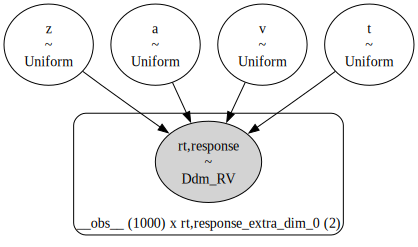

In [17]:
model.graph()

In [18]:
sample = model.sample()

Using default initvals. 



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [z]
>Slice: [a]
>Slice: [t]
>Slice: [v]
/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
100%|██████████| 4000/4000 [00:01<00:00, 2103.47it/s]


In [19]:
model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.510,0.013,0.485,0.534,0.000,0.0,1182.0,2018.0,1.0
a,1.460,0.027,1.410,1.510,0.001,0.0,1812.0,2348.0,1.0
t,0.334,0.021,0.297,0.375,0.001,0.0,1363.0,2095.0,1.0
v,0.515,0.033,0.452,0.574,0.001,0.0,1368.0,2141.0,1.0


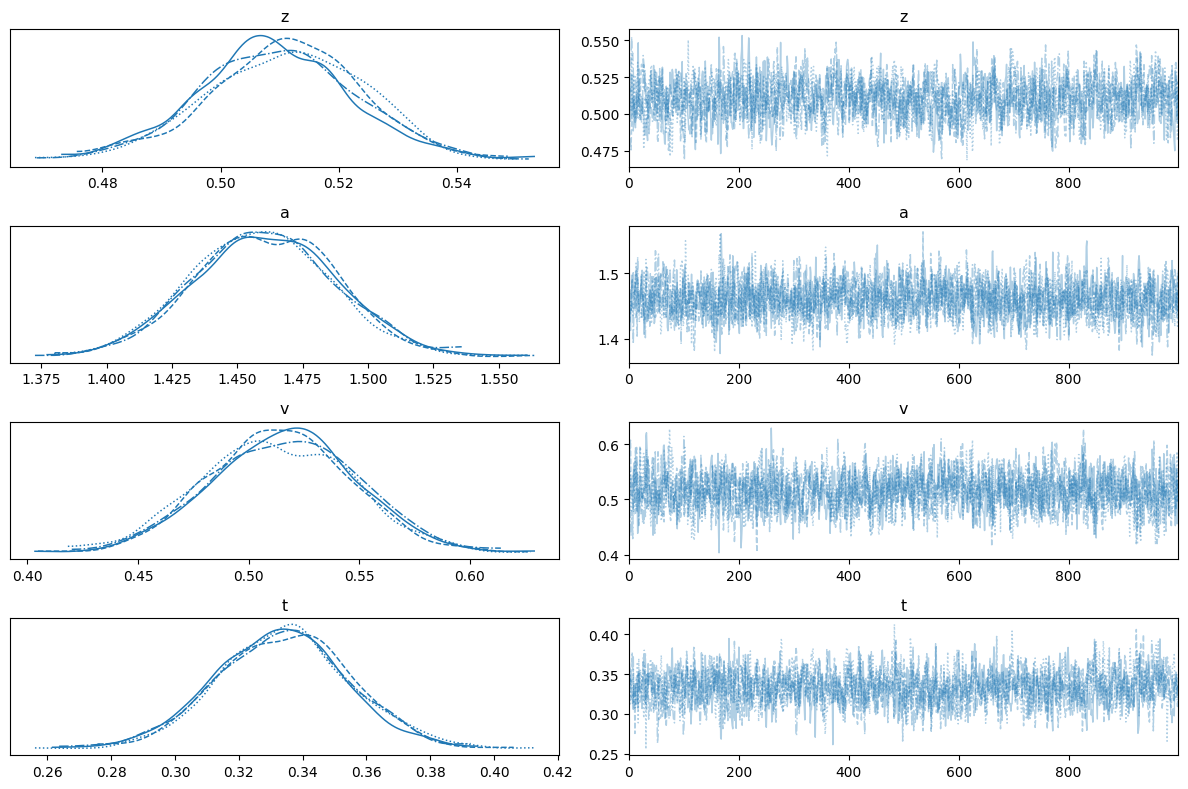

In [20]:
model.plot_trace()

Using the blackbox interface provides maximum flexibility on the user side. We hope you will find it useful!